# COMP5318 ASSIGNMENT 2: BEST ALGORITHM

**GROUP 144:**
- Aryan Bhatia : 490352056
- Mudit Malhotra : 490583269

In [34]:
# Loading the data set
%store -r data

# Parallelisation
from joblib import parallel_backend

# evaluation
from sklearn import metrics
import matplotlib.pyplot as plt

# Data
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Model Imports
from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, Embedding, Flatten, Dropout, Activation
from keras.models import Model

# Convolutional Neural Network (CNN)

In [35]:
# Subsetting the data to get 1,000,000 observations
data = data.sample(n = 1000000)

### Data Pre-Processing 

In [36]:
# Tokenizing and Sequence Padding for training data

MAX_SEQUENCE_LENGTH = 50
MAX_NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])

features = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(data['target']))

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', features.shape)
print('Shape of label tensor:', labels.shape)

# Train and test split

TRAIN_SPLIT = 0.2
indices  = np.arange(features.shape[0])
np.random.shuffle(indices)
features = features[indices]
labels   = labels[indices]
num_test_samples = int(TRAIN_SPLIT * features.shape[0])
x_train = features[:-num_test_samples]
y_train = labels[:-num_test_samples]
x_testing   = features[-num_test_samples:]
y_testing   = labels[-num_test_samples:]

# Test and validation split

VALIDATION_SPLIT = 0.5
indices  = np.arange(x_testing.shape[0])
np.random.shuffle(indices)
x_testing = x_testing[indices]
y_testing   = y_testing[indices]
num_val_samples = int(VALIDATION_SPLIT * x_testing.shape[0])
x_test = x_testing[:-num_val_samples]
y_test = y_testing[:-num_val_samples]
x_val   = x_testing[-num_val_samples:]
y_val   = y_testing[-num_val_samples:]


Found 287167 unique tokens.
Shape of data tensor: (1000000, 50)
Shape of label tensor: (1000000, 2)


### Creating Embedding Matrix

In [37]:
# Generating embedding index from Glove text file

embeddings_index = {}

# opening the downloaded glove embeddings file
f = open('glove.6B.300d.txt')
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word   = value = values[0]
    coefs  = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [38]:
# Creating embedding matrix

EMBEDDING_DIM = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Building the model

In [39]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NUM_WORDS,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH,trainable=False, weights = [embedding_matrix])
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(64, 3, activation='relu')(embedded_sequences)
x = Conv1D(32, 3, activation='relu')(x)
x = Conv1D(16, 3, activation='relu')(x)

x = GlobalMaxPooling1D()(x)

x = Flatten()(x)

x = Dropout(0.2)(x)
x = Dense(180, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='relu')(x)

output = Activation('sigmoid')(x)

model = Model(inputs=[sequence_input], outputs=[output])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 50, 300)           3000000   
                                                                 
 conv1d_9 (Conv1D)           (None, 48, 64)            57664     
                                                                 
 conv1d_10 (Conv1D)          (None, 46, 32)            6176      
                                                                 
 conv1d_11 (Conv1D)          (None, 44, 16)            1552      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                           

### Training the model

In [40]:
with parallel_backend('threading'):
    history = model.fit(x_train, y_train,batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
782/782 [==============================] - 112s 142ms/step - loss: 0.5361 - acc: 0.7286 - val_loss: 0.5123 - val_acc: 0.7495
Epoch 2/10
782/782 [==============================] - 106s 135ms/step - loss: 0.5018 - acc: 0.7545 - val_loss: 0.5097 - val_acc: 0.7521
Epoch 3/10
782/782 [==============================] - 105s 134ms/step - loss: 0.4906 - acc: 0.7619 - val_loss: 0.5048 - val_acc: 0.7563
Epoch 4/10
782/782 [==============================] - 108s 138ms/step - loss: 0.4832 - acc: 0.7667 - val_loss: 0.5004 - val_acc: 0.7578
Epoch 5/10
782/782 [==============================] - 106s 136ms/step - loss: 0.4769 - acc: 0.7708 - val_loss: 0.4973 - val_acc: 0.7585
Epoch 6/10
782/782 [==============================] - 108s 138ms/step - loss: 0.4721 - acc: 0.7742 - val_loss: 0.4971 - val_acc: 0.7564
Epoch 7/10
782/782 [==============================] - 107s 137ms/step - loss: 0.4682 - acc: 0.7764 - val_loss: 0.4968 - val_acc: 0.7580
Epoch 8/10
782/782 [============================

### Evaluating the model

In [41]:
# Helper Function for evaluation 
def evaluate(y_test, y_predict, model):
    print("\nMODEL: " + str(model))
    print('Accuracy: ', metrics.accuracy_score(y_test, y_predict))
    print("Precision: ", metrics.precision_score(y_test, y_predict))
    print("Recall: ", metrics.recall_score(y_test, y_predict))
    print("F1 Score: ", metrics.f1_score(y_test, y_predict))

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict)
    auc = metrics.roc_auc_score(y_test, y_predict)

    # Plot ROC for this label
    plt.plot(fpr,tpr,label="AUC = "+ "{:.2f}".format(auc))
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

3125/3125 [==============================] - 10s 3ms/step

MODEL: Convolutional Neural Network
Accuracy:  0.75665
Precision:  0.7556184816639081
Recall:  0.7582646281917874
F1 Score:  0.756939242301661


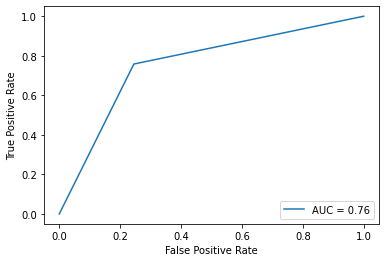

In [42]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

evaluate(y_test, y_pred, 'Convolutional Neural Network')

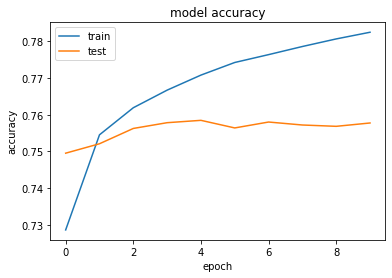

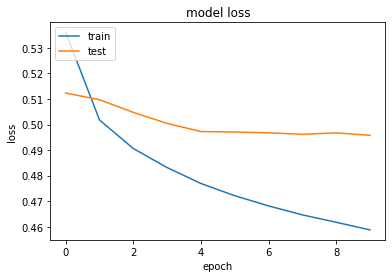

In [43]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

### Exporting Model

In [44]:
model.save("group144_pretrained_model", save_format="h5")